In [304]:
#bibliotecas básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import yfinance as yf

#estatística
from numpy import percentile
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

#análise
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import xgboost as xgb

#escolha do modelo
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#resultados
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#erros
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [305]:
train = pd.read_csv("train.csv", parse_dates= ['DT_COMPTC'])
test = pd.read_csv("full_dataset.csv", parse_dates= ['DT_COMPTC'])
test['Fluxo'] = test['Fluxo']/1000000

dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

# índices gerais
desemprego = pd.read_csv("features\\desemprego.csv", sep= ';', decimal= ',', parse_dates= ['DateTime'])
ipca = pd.read_csv("features\\ipca.csv", sep= ';', decimal= ',', parse_dates= ['DateTime'], usecols= [0,2])
pib = pd.read_csv("features\\pib.csv", sep= ';', decimal= ',', parse_dates= ['Data'])
selic = pd.read_csv("features\\selic.csv",sep= ';', decimal= '.', parse_dates=['Date'], date_parser= dateparse)

# índices da bolsa
iee = pd.read_csv("features\\iee.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
ifnc = pd.read_csv("features\\ifnc.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
imat = pd.read_csv("features\\imat.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
imob = pd.read_csv("features\\imob.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])

# mercado externo
bolsas_inter = yf.download(["^N100", "^FTSE", "^N225", "^HSI"], source='yahoo', start="2005-01-01")[['Volume', 'Close']]
bolsas_inter.columns = bolsas_inter.columns.map('.'.join).str.strip('.')
moedas_inter = yf.download(["EURBRL=X", "JPYBRL=X", "AUDBRL=X", "GBPBRL=X"], source= 'yahoo', start="2005-01-01")[['Close']].droplevel(0, axis=1)
dji = yf.download("^DJI", source= "yahoo", start="2005-01-01")[['Volume', 'Close']]
fedfunds = pd.read_csv("features\\fedfunds.csv", sep= ',', decimal= '.', parse_dates= ['DATE'])

selic.rename({'11 - Interest rate - Selic - % p.d.': 'SELIC'}, axis=1, inplace= True)
iee.rename({'Price': 'IEE'}, axis=1, inplace= True)
ifnc.rename({'Price': 'IFNC'}, axis=1, inplace= True)
imat.rename({'Price': 'IMAT'}, axis=1, inplace= True)
imob.rename({'Price': 'IMOB'}, axis=1, inplace= True)
dji.rename({'Volume': 'DJI.Volume', 'Close': 'DJI.Close'}, axis=1, inplace= True)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


In [306]:
def juntar(df1, df2):
        df1 = pd.merge(
            df2,
            df1,
            left_on=[df2[df2.columns[0]].dt.year, df2[df2.columns[0]].dt.month],
            right_on=[df1["DT_COMPTC"].dt.year, df1["DT_COMPTC"].dt.month],
            how="right",
            ).drop(["key_0", "key_1","DateTime", "Data","Mês"], axis=1, errors = 'ignore')

        return df1

In [307]:
#juntando os dataframes

#taxa de desemprego
train = juntar(train, desemprego)
test = juntar(test, desemprego)

#IPCA
train = juntar(train, ipca)
test = juntar(test, ipca)

#PIB
train = juntar(train, pib)
test = juntar(test, pib)

#Fed Funds Rate
train = pd.merge(train, fedfunds, left_on= 'DT_COMPTC', right_on='DATE', how='left').drop('DATE', axis=1)
test = pd.merge(test, fedfunds, left_on= 'DT_COMPTC', right_on='DATE', how='left').drop('DATE', axis=1)

#SELIC
train = pd.merge(train, selic, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)
test = pd.merge(test, selic, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)

#IEE
train = pd.merge(train, iee, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)
test = pd.merge(test, iee, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)

#IFNC
train = pd.merge(train, ifnc, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)
test = pd.merge(test, ifnc, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)

#IMAT
train = pd.merge(train, imat, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)
test = pd.merge(test, imat, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)

#IMOB
train = pd.merge(train, imob, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)
test = pd.merge(test, imob, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1)

#Bolsas internacionais
train = pd.merge(train, bolsas_inter, left_on= 'DT_COMPTC', right_on=bolsas_inter.index, how='left')
test = pd.merge(test, bolsas_inter, left_on= 'DT_COMPTC', right_on=bolsas_inter.index, how='left')

#Moedas internacionais
train = pd.merge(train, moedas_inter, left_on= 'DT_COMPTC', right_on=moedas_inter.index, how='left')
test = pd.merge(test, moedas_inter, left_on= 'DT_COMPTC', right_on=moedas_inter.index, how='left')

#Dow Jones Industrial Average
train = pd.merge(train, dji, left_on= 'DT_COMPTC', right_on=dji.index, how='left')
test = pd.merge(test, dji, left_on= 'DT_COMPTC', right_on=dji.index, how='left')

In [308]:
# preenchendo os valores nulos por foward e back fill
train.fillna(method='ffill', inplace=True)
train.fillna(method='backfill', inplace=True)

test.fillna(method='ffill', inplace=True)
test.fillna(method='backfill', inplace=True)

In [210]:
train.isna().sum()

PIB mensal             0
IPCA ocorrido          0
Taxa de Desocupação    0
DT_COMPTC              0
IBOV                   0
Dol                    0
NDX                    0
SPX                    0
Fluxo                  0
DFF                    0
SELIC                  0
IEE                    0
IFNC                   0
IMAT                   0
IMOB                   0
Volume.^FTSE           0
Volume.^HSI            0
Volume.^N100           0
Volume.^N225           0
Close.^FTSE            0
Close.^HSI             0
Close.^N100            0
Close.^N225            0
AUDBRL=X               0
EURBRL=X               0
GBPBRL=X               0
JPYBRL=X               0
DJI.Volume             0
DJI.Close              0
dtype: int64

c:\Users\vlaub\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


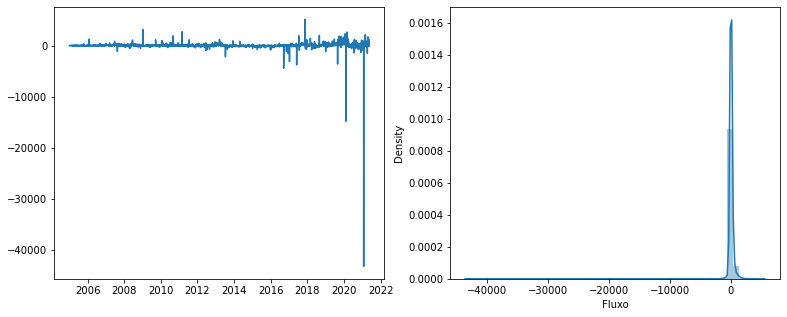

In [250]:
# análise da serie temporal
train = train.set_index(pd.to_datetime(train['DT_COMPTC']))
test = test.set_index(pd.to_datetime(test['DT_COMPTC']))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(train['Fluxo'])
plt.subplot(1,2,2)
sns.distplot(train['Fluxo'])
plt.show()

In [212]:
# espaço interquartil
fluxo = train['Fluxo']

q25, q75 = percentile(fluxo, 25), percentile(fluxo, 75)
iqr = q75 - q25

# separando os outliers
corte = iqr * 5
lower, upper = q25 - corte, q75 + corte

outliers = [x for x in fluxo if x < lower or x > upper]

#removendo outliers
fluxo = [x for x in fluxo if x > lower and x < upper]

print('Outliers identificados: %d' % len(outliers))
print('Observações não-outliers: %d' % len(fluxo))

train_og = train.copy()

train['Fluxo'] = np.where(
    train['Fluxo'] > upper,
    upper,
    np.where(
        train['Fluxo'] < lower,
        lower,
        train['Fluxo']
    )
)

Outliers identificados: 116
Observações não-outliers: 4005


c:\Users\vlaub\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


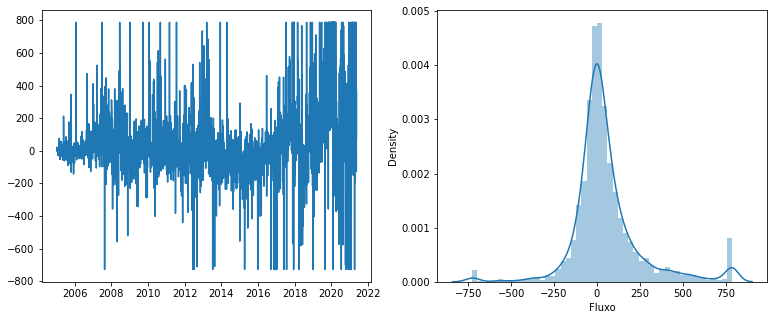

In [213]:
# análise gráfica sem outliers
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(train['Fluxo'])
plt.subplot(1,2,2)
sns.distplot(train['Fluxo'])
plt.show()

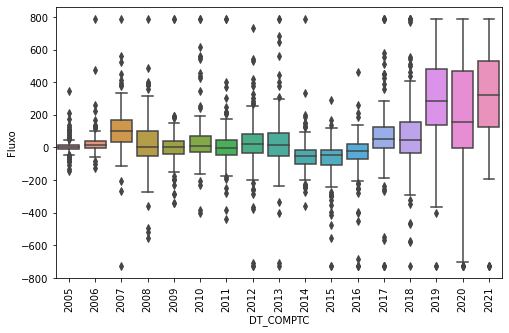

In [214]:
# análise da tendência por boxplot
plt.figure(figsize=(8,5))
ax = sns.boxplot(data = train, x=train.index.year,y='Fluxo')
for item in ax.get_xticklabels():
    item.set_rotation(90)


plt.show()

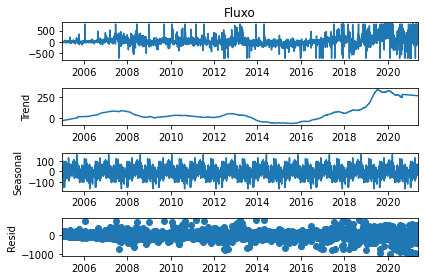

In [215]:
# análise da tendência e sazonalidade por decomposição aditiva
result_add = seasonal_decompose(train['Fluxo'], model='additive', extrapolate_trend='freq', period = 365)

# plot
result_add.plot()
plt.show()

In [216]:
# correlação de Pearson

train.corr(method='pearson')

,PIB mensal,IPCA ocorrido,Taxa de Desocupação,IBOV,Dol,NDX,SPX,Fluxo,DFF,SELIC,...,Close.^FTSE,Close.^HSI,Close.^N100,Close.^N225,AUDBRL=X,EURBRL=X,GBPBRL=X,JPYBRL=X,DJI.Volume,DJI.Close
PIB mensal,1.000000,-0.091477,0.810360,0.746599,0.785860,0.876101,0.887574,0.224951,-0.502174,-0.702112,...,0.690365,0.744556,0.566829,0.702500,0.883970,0.763698,0.609627,0.862160,0.109551,0.899474
IPCA ocorrido,-0.091477,1.000000,-0.308838,-0.445085,-0.142858,-0.271524,-0.237690,-0.288423,-0.210065,0.467010,...,-0.121701,-0.240866,-0.174649,-0.170361,-0.099225,-0.180913,-0.033059,-0.187318,-0.572453,-0.278671
Taxa de Desocupação,0.810360,-0.308838,1.000000,0.720765,0.881961,0.894480,0.895149,0.274584,-0.151736,-0.572654,...,0.592864,0.620291,0.690621,0.808258,0.865529,0.857539,0.744756,0.865683,0.443119,0.893802
IBOV,0.746599,-0.445085,0.720765,1.000000,0.635266,0.833133,0.797355,0.436373,-0.245928,-0.867164,...,0.524277,0.779689,0.572247,0.625344,0.723082,0.669621,0.479250,0.754582,0.340542,0.818101
Dol,0.785860,-0.142858,0.881961,0.635266,1.000000,0.925298,0.904620,0.257833,-0.166465,-0.543921,...,0.459589,0.481057,0.664869,0.831061,0.946781,0.982898,0.942141,0.938665,0.393568,0.878094
NDX,0.876101,-0.271524,0.894480,0.833133,0.925298,1.000000,0.977992,0.326361,-0.243805,-0.732875,...,0.595507,0.687900,0.714234,0.853496,0.963473,0.938257,0.831078,0.936526,0.361142,0.964812
SPX,0.887574,-0.237690,0.895149,0.797355,0.904620,0.977992,1.000000,0.327479,-0.151270,-0.668716,...,0.732161,0.745870,0.816047,0.916816,0.934619,0.902741,0.822598,0.878097,0.309266,0.994187
Fluxo,0.224951,-0.288423,0.274584,0.436373,0.257833,0.326361,0.327479,1.000000,0.104361,-0.335566,...,0.204188,0.254824,0.305844,0.289184,0.237403,0.262245,0.220843,0.261949,0.257030,0.340822
DFF,-0.502174,-0.210065,-0.151736,-0.245928,-0.166465,-0.243805,-0.151270,0.104361,1.000000,0.374805,...,0.053846,-0.184564,0.327844,0.146810,-0.332192,-0.172533,0.023300,-0.389525,0.230080,-0.150615
SELIC,-0.702112,0.467010,-0.572654,-0.867164,-0.543921,-0.732875,-0.668716,-0.335566,0.374805,1.000000,...,-0.383942,-0.686612,-0.362406,-0.463236,-0.675453,-0.604737,-0.382764,-0.718848,-0.306358,-0.691347


In [217]:
y, X = train['Fluxo'], train.drop(['Fluxo','DT_COMPTC'], axis=1)

#Seleção de features por testes estatisticos univariáveis (Select K Best)

skb = SelectKBest(score_func=f_regression, k=5)

skb = skb.fit(X,y)

dfscores = pd.DataFrame(skb.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  
print(featureScores.nlargest(10,'Score'))  

        Feature       Score
3          IBOV  968.832634
10         IFNC  828.106006
9           IEE  739.934876
11         IMAT  691.091225
26    DJI.Close  541.343023
8         SELIC  522.673491
6           SPX  494.794440
5           NDX  491.020498
19  Close.^N100  425.053080
20  Close.^N225  375.897264


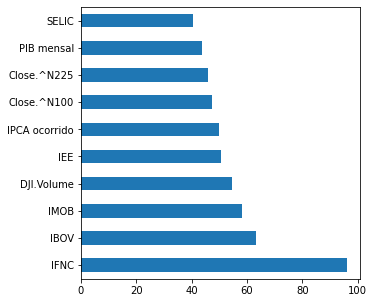

In [218]:
#Meta estimador de features por árvores de decisão randomizadas (extra-trees)

model = ExtraTreesRegressor(n_estimators=200).fit(X,y)

perm = permutation_importance(model, X, y, scoring= 'neg_root_mean_squared_error')

feat_importances = pd.Series(perm.importances_mean, index=X.columns)

plt.figure(figsize=(5,5))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [219]:
# Cortando a time series

train = train.loc['2012':'2018']
test = test.loc['2021-05-19':'2022-07-26']

features = ['IFNC', 'IEE', 'IMOB', 'Dol', 'SPX', 'NDX']

y_train, X_train = train['Fluxo'], train[features]

y_test, X_test = test['Fluxo'], test[features]

y, X = train['Fluxo'], train[features]

# normalização dos dados das variáveis 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

<ipython-input-220-ffd143421768>:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


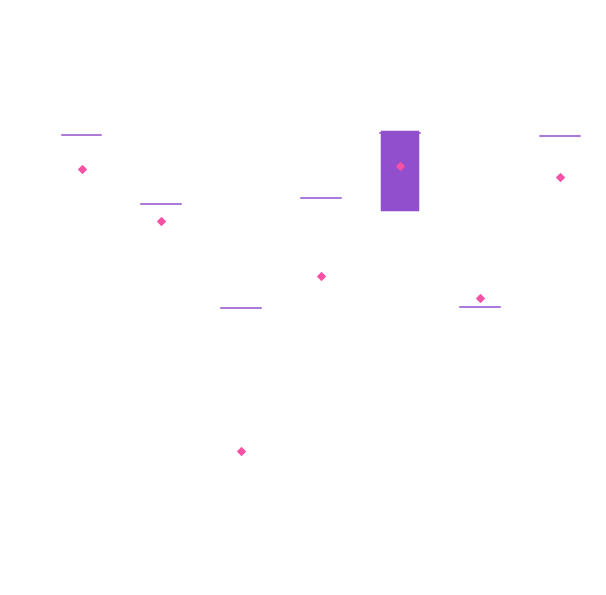

In [220]:
from sklearn.model_selection import TimeSeriesSplit

# ensemble do modelo por stacking
@ignore_warnings(category=ConvergenceWarning)
def get_stacking():
	# modelos base
	level0 = list()
	level0.append(('KNeighbors', KNeighborsRegressor()))
	level0.append(('SVR', SVR(kernel='poly')))
	level0.append(('XGBoost', xgb.XGBRegressor()))
	level0.append(('Decision', DecisionTreeRegressor()))
	level0.append(('GradientBoosting', GradientBoostingRegressor()))
	# modelo meta learner
	level1 = LinearRegression()
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# modelos para avaliar
def get_models():
	models = dict()
	models['SVR'] = SVR(kernel='poly')
	models['KNeighbors'] = KNeighborsRegressor()
	models['DecisionTree'] = DecisionTreeRegressor()
	models['XGBoost'] = xgb.XGBRegressor()
	models['MLP'] = MLPRegressor(shuffle=False,
                    activation='relu',
                    alpha = 0.05,
                    hidden_layer_sizes= (100,),
                    learning_rate='adaptive',
                    solver = 'sgd',
                    max_iter= 200,
                    random_state=98)
	models['GradientBoosting'] = GradientBoostingRegressor()
	models['Stacking'] = get_stacking()
	return models
 
# avaliação dos modelos por cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=5)
	scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# models = get_models()

# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X_train_norm, y_train)
# 	results.append(scores)
# 	names.append(name)
# 	print('%s %.3f (%.3f)' % (name, -np.mean(scores), np.std(scores)))

mfont = {'fontname':'Montserrat', 'size': 20}

plt.figure(figsize=(10,10))
plt.title('Validação cruzada dos modelos',**mfont)

ax = plt.axes()
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_alpha(0)
ax.spines['right'].set_alpha(0)
ax.spines['left'].set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.title.set_color('white')

ax.patch.set_facecolor('white')
ax.patch.set_alpha(0)

boxprops = dict(linestyle='-', linewidth=1.5, color='white')
medianprops = dict(linestyle='-', linewidth=1.5, color='#914ecd')
meanpointprops = dict(marker='D', markeredgecolor='#f751a5',
                      markerfacecolor='#f751a5')

whiskersprop = dict(color='white',linewidth=1.5)
capprops = dict(color='white',linewidth=1.5)

bplot = plt.boxplot(results, capprops = capprops, whiskerprops = whiskersprop, patch_artist = True, labels=names,showfliers=False, showmeans=True, medianprops=medianprops, meanprops= meanpointprops, boxprops=boxprops, flierprops=flierprops)

for patch, color,alpha in zip(bplot['boxes'], ['white', 'white','white', 'white','#914ecd', 'white','white'], [0.5,0.5,0.5,0.5,0.5,0.5,0.5]):
    patch.set_facecolor(color), patch.set_alpha(1)
 
plt.show()

plt.show()

In [221]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive','invscaling'],
}

model = MLPRegressor(shuffle=False)

@ignore_warnings(category=ConvergenceWarning)
def gridsearch(model, params, X, y):
    grid = GridSearchCV(model,
                        params,
                        scoring= 'neg_root_mean_squared_error',
                        cv = KFold(n_splits=5),
                        error_score=np.nan,
                        n_jobs=-1,
                        verbose=2).fit(X_train_norm, y_train)
    return grid

# descomentar para rodar o gridsearch
# gridsearch(model, params, X_train_norm, y_train).best_params_k

In [222]:
#modelo de rede neural para a predição
mlp = MLPRegressor(shuffle = False,
                    activation='relu',
                    alpha = 0.05,
                    hidden_layer_sizes= (100,),
                    learning_rate='adaptive',
                    solver = 'sgd',
                    max_iter= 10000,
                    random_state=98).fit(X_train_norm, y_train)

y_pred = mlp.predict(X_test_norm)

In [223]:
#RMSE do modelo atual comparado com o da primeira etapa
comp = pd.read_csv("forecast2.0.csv")

rmse_teste = mean_squared_error(y_test, y_pred, squared=False)
rmse_comp = mean_squared_error(y_test, comp['Fluxo'], squared=False)

mae_teste = mean_absolute_error(y_test, y_pred)
mae_comp = mean_absolute_error(y_test, comp['Fluxo'])

mape_teste = mean_absolute_percentage_error(y_test, y_pred)
mape_comp = mean_absolute_percentage_error(y_test, comp['Fluxo'])


print('RMSE do teste : %.3f' % (rmse_teste))
print('RMSE da competição : %.3f' % (rmse_comp))

print('RMA do teste : %.3f' % (rma_teste))
print('RMA da competição : %.3f' % (rma_comp))

print('MAPE do teste : %.3f' % (mape_teste))
print('MAPE da competição : %.3f' % (mape_comp))

RMSE do teste : 697.522
RMSE da competição : 686.363
RMA do teste : 409.167
RMA da competição : 442.268
MAPE do teste : 1.790
MAPE da competição : 1.744


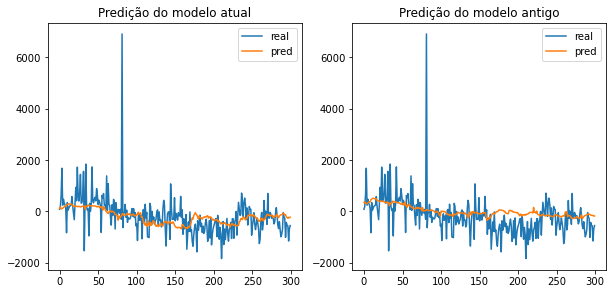

In [ ]:
plt.figure(figsize= (10,10))

plt.subplot(2,2,1)
plt.title('Predição do modelo atual')
plt.plot(y_test.values, label = "real")
plt.plot(y_pred, label = "pred")
plt.legend()

plt.subplot(2,2,2)
plt.title('Predição do modelo antigo')
plt.plot(y_test.values, label = "real")
plt.plot(comp['Fluxo'], label = "pred")
plt.legend()

plt.show()

In [ ]:
# y_forecast = pd.DataFrame(y_forecast, index=test['DT_COMPTC'], columns=['Fluxo'])

# y_forecast.to_csv('forecast6.0.csv', encoding='utf-8')

# y_forecast

In [ ]:
# walk foward validation

#1 mês
cv = TimeSeriesSplit(n_splits=5, test_size= 30)

scores = cross_val_score(mlp, X_train_norm, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')
print(scores)
print('%.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

[-3.19378654 -1.47574481 -1.84462474 -1.17472267 -7.78920179]
3.096 (2.446)


In [ ]:
#15 dias
cv = TimeSeriesSplit(n_splits=5, test_size= 15)
scores = cross_val_score(mlp, X_train_norm, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')

print(scores)
print('%.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

[-3.48912219 -0.88155751 -2.2381393  -2.76484199 -1.89120607]
2.253 (0.872)


In [224]:
#trimestre
cv = TimeSeriesSplit(n_splits=5, test_size= 90)
scores = cross_val_score(mlp, X_train_norm, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')

print(scores)
print('%.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

[-10.70815462  -1.53262189 -14.81607741  -1.92318753  -5.25518337]
6.847 (5.166)


In [225]:
#semestre
cv = TimeSeriesSplit(n_splits=5, test_size=180)
for train_index, test_index in cv.split(X_train_norm):
    print("TRAIN:", train_index, "TEST:", test_index)
scores = cross_val_score(mlp, X_train_norm, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')

print(scores)
print('%.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [254]:
#ano
cv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(mlp, X_train_norm, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')

print(scores)
print('%.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

ValueError: Found input variables with inconsistent numbers of samples: [1757, 757]

In [309]:
treino = train.loc['2016':'2018']
test = train.loc['2020':'2021.2']

features = ['IFNC', 'IEE', 'IMOB', 'Dol', 'SPX', 'NDX']

y_train, X_train = treino['Fluxo'], treino[features]

y_test, X_test = test['Fluxo'], test[features]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

mlp = MLPRegressor(shuffle = False,
                    activation='relu',
                    alpha = 0.05,
                    hidden_layer_sizes= (100,),
                    learning_rate='adaptive',
                    solver = 'sgd',
                    max_iter= 10000,
                    random_state=98).fit(X_train_norm, y_train)

y_pred = mlp.predict(X_test_norm)

In [310]:
rmse_teste = mean_squared_error(y_test, y_pred, squared=False)

mae_teste = mean_absolute_error(y_test, y_pred)

mape_teste = mean_absolute_percentage_error(y_test, y_pred)


print('RMSE do teste : %.3f' % (rmse_teste))

print('RMA do teste : %.3f' % (mae_teste))

print('MAPE do teste : %.3f' % (mape_teste))

RMSE do teste : 479.040
RMA do teste : 394.031
MAPE do teste : 1.756
